In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import geopandas as gpd
from shapely.geometry import Point
import requests
from PIL import Image
from io import BytesIO
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.auto import tqdm

In [129]:
df_train_split = joblib.load("df_train_split.pkl")
df_val_split = joblib.load("df_val_split.pkl")
X_train_tab = joblib.load("X_train_tab.pkl")
X_val_tab = joblib.load("X_val_tab.pkl")
y_train_tab = joblib.load("y_train_tab.pkl")
y_val_tab = joblib.load("y_val_tab.pkl")
scaler = joblib.load("scaler_xgb.pkl")

In [130]:
X_train_scaled_xgb = scaler.fit_transform(X_train_tab)
X_val_scaled_xgb   = scaler.transform(X_val_tab)

In [131]:
xgb_model = xgb.XGBRegressor(n_estimators=500,learning_rate=0.05,max_depth=7,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0,objective="reg:squarederror",random_state=7)

xgb_model.fit(X_train_scaled_xgb, y_train_tab)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [132]:
y_pred_xgb = xgb_model.predict(X_val_scaled_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_val_tab, y_pred_xgb))
r2_xgb  = r2_score(y_val_tab, y_pred_xgb)

print(rmse_xgb, r2_xgb)

115016.49829480986 0.897350549697876


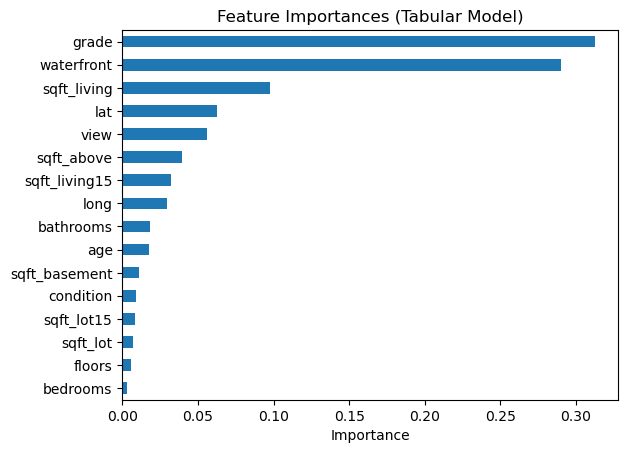

In [133]:
imp = pd.Series(xgb_model.feature_importances_,index=features).sort_values()

imp.plot(kind="barh")
plt.title("Feature Importances (Tabular Model)")
plt.xlabel("Importance")
plt.show()

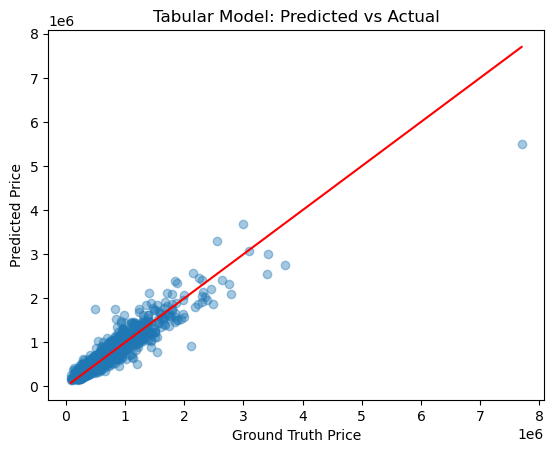

In [134]:
plt.scatter(y_val_tab, y_pred_xgb, alpha=0.4)
plt.plot([y_val_tab.min(), y_val_tab.max()],[y_val_tab.min(), y_val_tab.max()],'r')
plt.xlabel("Ground Truth Price")
plt.ylabel("Predicted Price")
plt.title("Tabular Model: Predicted vs Actual")
plt.show()

In [135]:
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler_xgb.pkl') 

['scaler_xgb.pkl']

In [136]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [137]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

In [138]:
class HouseImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Pre-check valid images (kernel-safe)
        self.valid_indices = []
        for i in range(len(self.df)):
            img_path = os.path.join(self.image_dir, f"{self.df.loc[i, 'id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(i)

        if len(self.valid_indices) == 0:
            raise RuntimeError("No valid images found!")

        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.loc[real_idx]

        img_path = os.path.join(self.image_dir, f"{row['id']}.png")

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), (128, 128, 128))

        if self.transform:
            image = self.transform(image)

        # Normalize price (VERY IMPORTANT)
        price = torch.tensor(row["price"] / 1e6, dtype=torch.float32)

        return image, price

In [139]:
IMAGE_DIR = "../data/raw/images_train"

train_dataset = HouseImageDataset(
    df_train_split,
    image_dir=IMAGE_DIR,
    transform=train_transform)

val_dataset = HouseImageDataset(
    df_val_split,
    image_dir=IMAGE_DIR,
    transform=val_transform)

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True)


✓ Found 12888/12888 valid images
✓ Found 3222/3222 valid images


In [140]:
class ImageOnlyRegressor(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()

        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1
        )

        # Freeze entire backbone
        for param in self.backbone.parameters():
            param.requires_grad = True


        # Replace FC head
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)

✓ Batch shape: torch.Size([16, 3, 224, 224])
✓ Target shape: torch.Size([16])
Price range: $0 to $1
Normalised


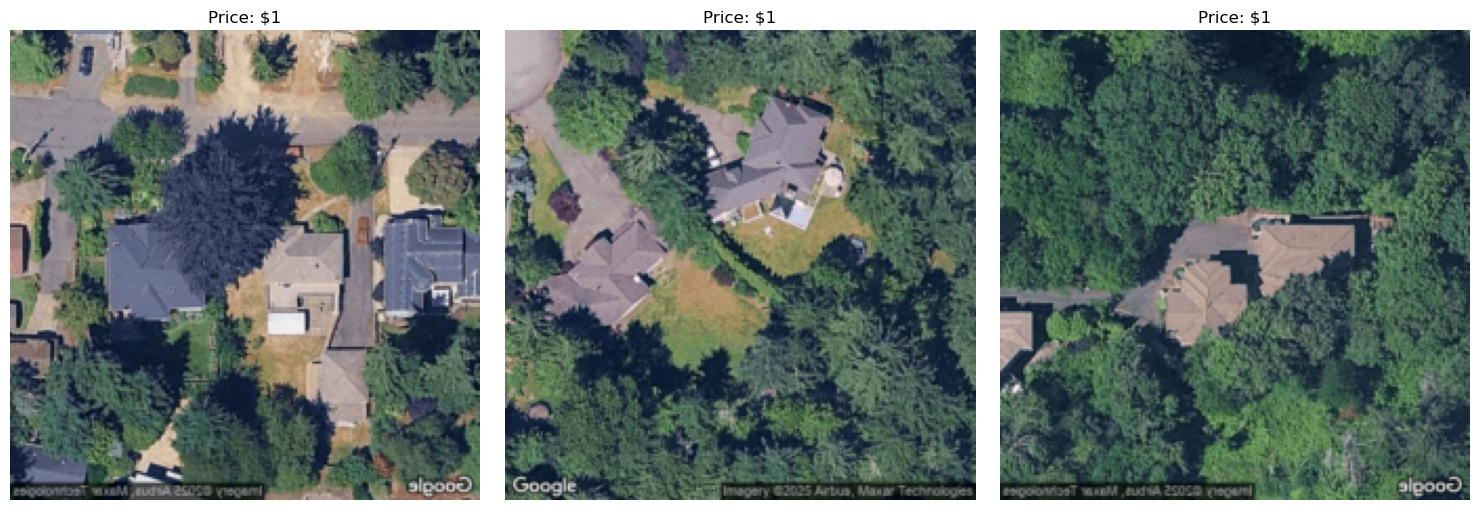

In [141]:
sample_images, sample_targets = next(iter(train_loader))
print(f"✓ Batch shape: {sample_images.shape}")
print(f"✓ Target shape: {sample_targets.shape}")
print(f"Price range: ${sample_targets.min().item():,.0f} to ${sample_targets.max().item():,.0f}")
print(f"Normalised")

# Visualize a sample image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = sample_images[i].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Price: ${sample_targets[i].item():,.0f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [142]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


model = ImageOnlyRegressor().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

Using device: mps
Total parameters: 11,341,633
Trainable parameters: 11,341,633


In [143]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping (VERY IMPORTANT)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)


In [144]:
def validate(model, loader):
    model.eval()
    preds_norm, trues_norm = [], []
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            preds_norm.append(outputs.cpu().numpy())
            trues_norm.append(targets.cpu().numpy())

    preds_norm = np.concatenate(preds_norm)
    trues_norm = np.concatenate(trues_norm)

    # ---- de-normalize to dollars ----
    preds = preds_norm * 1e6
    trues = trues_norm * 1e6

    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)

    return val_loss / len(loader), rmse, mae, r2, preds, trues


In [148]:
CHECKPOINT_DIR = "../models"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "image_only_checkpoint.pth")
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "image_only_best.pth")
HISTORY_PATH = os.path.join(CHECKPOINT_DIR, "training_history.json")

In [149]:
def save_checkpoint(epoch, model, optimizer, best_rmse):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_rmse": best_rmse
    }, CHECKPOINT_PATH)

In [150]:
def load_checkpoint(model, optimizer):
    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        start_epoch = checkpoint["epoch"] + 1
        best_rmse = checkpoint["best_rmse"]
        print(f"✓ Resuming from epoch {checkpoint['epoch'] + 1}")
        return start_epoch, best_rmse
    else:
        print("✓ No checkpoint found. Starting fresh.")
        return 0, float("inf")


In [152]:
EPOCHS = 10

train_losses = []
val_losses = []
val_rmses = []
val_r2s = []

RUN_TRAINING = True   # set False when you only want to load & plot


if RUN_TRAINING:
    start_epoch, best_val_rmse = load_checkpoint(model, optimizer)
else:
    start_epoch, best_val_rmse = 0, float("inf")


if RUN_TRAINING:
    for epoch in range(start_epoch, EPOCHS):
        print("\n" + "=" * 70)
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print("=" * 70)

        train_loss = train_one_epoch(model, train_loader)
        train_losses.append(train_loss)
        val_loss, val_rmse, val_mae, val_r2, val_preds, val_trues = validate(model, val_loader)
        val_losses.append(val_loss)
        val_rmses.append(val_rmse)
        val_r2s.append(val_r2)

        # Save training history every epoch
        history = {
          "train_losses": train_losses,
          "val_losses": val_losses,
          "val_rmses": val_rmses,
          "val_r2s": val_r2s
        }

        with open(HISTORY_PATH, "w") as f:
           json.dump(history, f)


        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss:   {val_loss:.4f}")
        print(f"Val RMSE:   {val_rmse:.4f}")
        print(f"Val MAE:    {val_mae:.4f}")
        print(f"Val R2:     {val_r2:.4f}")

        # Save checkpoint EVERY epoch
        save_checkpoint(epoch, model, optimizer, best_val_rmse)

        # Save best model
        if val_rmse < best_val_rmse:
           best_val_rmse = val_rmse
           torch.save(model.state_dict(), BEST_MODEL_PATH)
           print("✓ Best model updated")


✓ No checkpoint found. Starting fresh.

Epoch 1/10


Train Loss: 0.1554
Val Loss:   0.1150
Val RMSE:   339122.6357
Val MAE:    208760.6094
Val R2:     0.1076
✓ Best model updated

Epoch 2/10


Train Loss: 0.1126
Val Loss:   0.0905
Val RMSE:   300915.9947
Val MAE:    177992.9375
Val R2:     0.2974
✓ Best model updated

Epoch 3/10


Train Loss: 0.0979
Val Loss:   0.0927
Val RMSE:   304547.4683
Val MAE:    192703.9062
Val R2:     0.2803

Epoch 4/10


Train Loss: 0.0897
Val Loss:   0.0910
Val RMSE:   301528.0381
Val MAE:    172682.0938
Val R2:     0.2945

Epoch 5/10


Train Loss: 0.0865
Val Loss:   0.0784
Val RMSE:   280024.6846
Val MAE:    159314.4688
Val R2:     0.3915
✓ Best model updated

Epoch 6/10


Train Loss: 0.0812
Val Loss:   0.0759
Val RMSE:   275446.5277
Val MAE:    163579.4531
Val R2:     0.4113
✓ Best model updated

Epoch 7/10


Train Loss: 0.0775
Val Loss:   0.0837
Val RMSE:   289245.9874
Val MAE:    162158.5469
Val R2:     0.3508

Epoch 8/10


Train Loss: 0.0758
Val Loss:   0.0806
Val RMSE:   283750.6529
Val MAE:    159092.9844
Val R2:     0.3752

Epoch 9/10


Train Loss: 0.0718
Val Loss:   0.0723
Val RMSE:   268700.8122
Val MAE:    165265.5938
Val R2:     0.4398
✓ Best model updated

Epoch 10/10


Train Loss: 0.0674
Val Loss:   0.0713
Val RMSE:   266802.9280
Val MAE:    156645.0781
Val R2:     0.4476
✓ Best model updated


In [153]:
state_dict = torch.load(
    "../models/image_only_best.pth",
    map_location=device
)

model.load_state_dict(state_dict)
model.eval()

print("Loaded best image-only model weights")


Loaded best image-only model weights


In [154]:
if not RUN_TRAINING:
    with open(HISTORY_PATH, "r") as f:
        history = json.load(f)

    train_losses = history["train_losses"]
    val_losses = history["val_losses"]
    val_rmses = history["val_rmses"]
    val_r2s = history["val_r2s"]

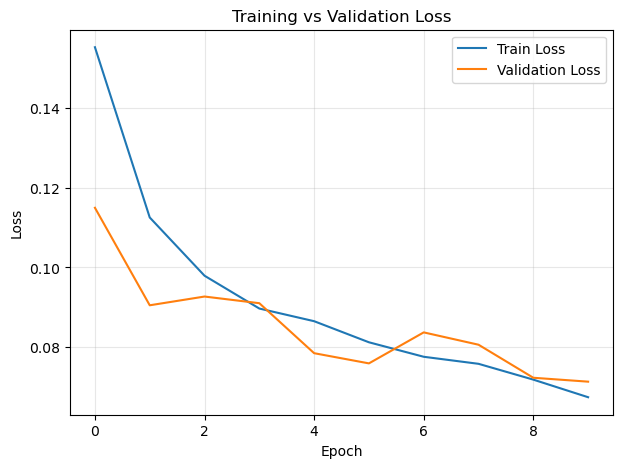

In [155]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

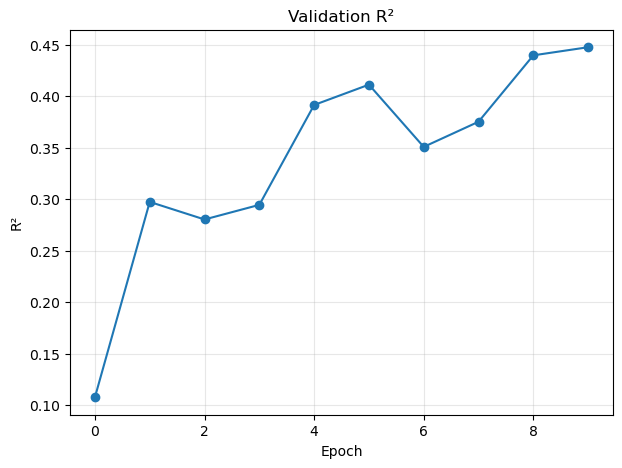

In [156]:
plt.figure(figsize=(7,5))
plt.plot(val_r2s, marker="o")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Validation R²")
plt.grid(alpha=0.3)
plt.show()


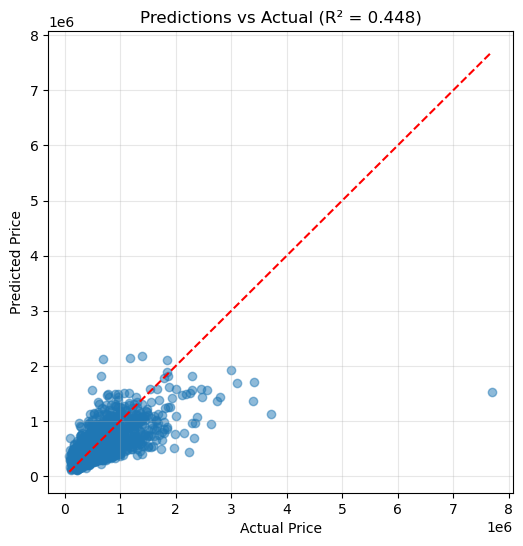

In [157]:
val_trues = np.array(val_trues)
val_preds = np.array(val_preds)

plt.figure(figsize=(6,6))
plt.scatter(val_trues, val_preds, alpha=0.5)

min_v = min(val_trues.min(), val_preds.min())
max_v = max(val_trues.max(), val_preds.max())

plt.plot([min_v, max_v], [min_v, max_v], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predictions vs Actual (R² = {val_r2s[-1]:.3f})")
plt.grid(alpha=0.3)
plt.show()


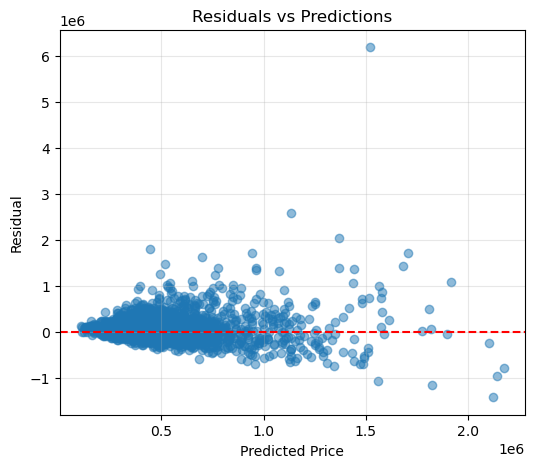

In [158]:
residuals = val_trues - val_preds

plt.figure(figsize=(6,5))
plt.scatter(val_preds, residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color="r")
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.grid(alpha=0.3)
plt.show()


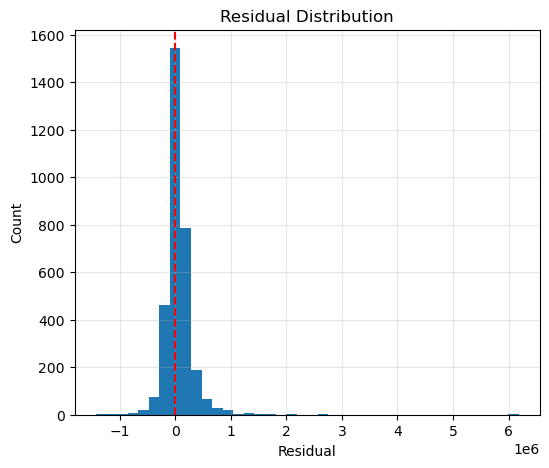

In [159]:
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=40)
plt.axvline(0, linestyle="--", color="r")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.grid(alpha=0.3)
plt.show()


In [160]:
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

In [161]:
class ImageRegressorWithFeatures(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = nn.Sequential(*list(trained_model.backbone.children())[:-2])
        self.pool = trained_model.backbone.avgpool
        self.fc = trained_model.backbone.fc

    def forward(self, x):
        feat = self.features(x)
        pooled = self.pool(feat).view(x.size(0), -1)
        out = self.fc(pooled)
        return out, feat

In [162]:
cam_model = ImageRegressorWithFeatures(model).to(device)
cam_model.eval()


ImageRegressorWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [163]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            self.activations.requires_grad_(True)

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        output, _ = self.model(input_tensor)
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam


In [164]:
target_layer = cam_model.features[-1]
gradcam = GradCAM(cam_model, target_layer)

sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

cam = gradcam.generate(input_tensor)
cam = cam.squeeze().detach().cpu().numpy()

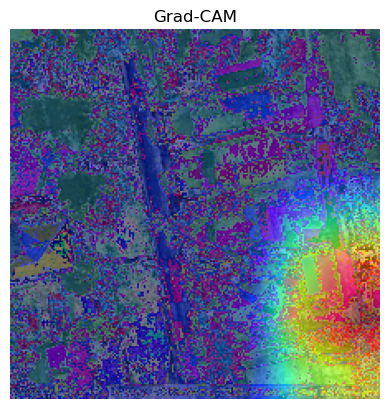

In [165]:
cam_resized = F.interpolate(
    torch.tensor(cam).unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

plt.imshow(T.ToPILImage()(sample_img))
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()


In [166]:
xgb_model = joblib.load("xgb_model.pkl")
scaler = joblib.load("scaler_xgb.pkl")

X_val_scaled = scaler.transform(X_val_tab)
y_pred_xgb = xgb_model.predict(X_val_scaled)


In [167]:
cnn_preds = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        preds = model(images).cpu().numpy()
        cnn_preds.extend(preds)

y_pred_cnn = np.array(cnn_preds).reshape(-1)


In [168]:
X_fusion = np.column_stack([y_pred_xgb, y_pred_cnn])

fusion_model = LinearRegression()
fusion_model.fit(X_fusion, y_val_tab)

y_pred_fusion = fusion_model.predict(X_fusion)

rmse_fusion = np.sqrt(mean_squared_error(y_val_tab, y_pred_fusion))
r2_fusion = r2_score(y_val_tab, y_pred_fusion)

print(f"Fusion Model → RMSE: {rmse_fusion:,.0f}, R²: {r2_fusion:.4f}")


Fusion Model → RMSE: 114,902, R²: 0.8976


In [169]:
joblib.dump(fusion_model, 'fusion_model.pkl')

['fusion_model.pkl']

In [170]:
results_df = pd.DataFrame({
    "Model": ["XGBoost (Tabular)", "XGB + CNN Fusion"],
    "RMSE": [rmse_xgb, rmse_fusion],
    "R2 Score": [r2_xgb, r2_fusion]
})

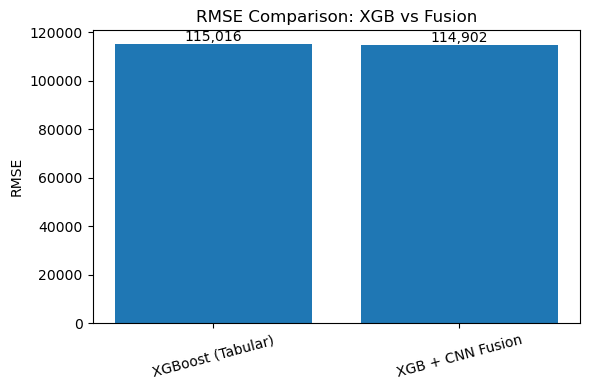

In [171]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison: XGB vs Fusion")
plt.xticks(rotation=15)
for i, v in enumerate(results_df["RMSE"]):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

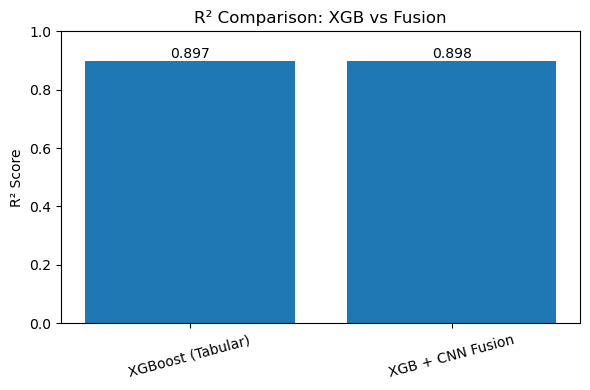

In [172]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.ylabel("R² Score")
plt.title("R² Comparison: XGB vs Fusion")
plt.ylim(0, 1)
plt.xticks(rotation=15)
for i, v in enumerate(results_df["R2 Score"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [173]:
df_test = pd.read_excel("../data/raw/test2.xlsx")

In [174]:
df_test['age'] = 2025 - df_test['yr_built']

In [175]:
X_test_tab = df_test[features]

In [176]:
xgb_model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler_xgb.pkl')

In [177]:
checkpoint = torch.load("../models/image_only_best.pth", map_location=device)

cnn_model = ImageOnlyRegressor(dropout=0.5).to(device)
cnn_model.load_state_dict(checkpoint)
cnn_model.eval()


ImageOnlyRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [178]:
fusion_model = joblib.load('fusion_model.pkl')

In [179]:
X_test_xgb_scaled = scaler.transform(X_test_tab)
test_pred_xgb = xgb_model.predict(X_test_xgb_scaled)

In [180]:
class HouseTestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Pre-check valid images (kernel-safe)
        self.valid_indices = []
        for i in range(len(self.df)):
            img_path = os.path.join(self.image_dir, f"{self.df.loc[i, 'id']}.png")
            if os.path.exists(img_path):
                self.valid_indices.append(i)

        if len(self.valid_indices) == 0:
            raise RuntimeError("No valid images found!")

        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.loc[real_idx]

        img_path = os.path.join(self.image_dir, f"{row['id']}.png")

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), (128, 128, 128))

        if self.transform:
            image = self.transform(image)

        return image, row["id"]

In [181]:
test_dataset = HouseTestDataset(df_test, image_dir="../data/raw/images_test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

test_pred_cnn = []
with torch.no_grad():
    for images, _ in test_loader:  
        images = images.to(device)
        preds = cnn_model(images).cpu().numpy()
        test_pred_cnn.extend(preds)
test_pred_cnn = np.array(test_pred_cnn)

✓ Found 5404/5404 valid images


In [183]:
X_test_fusion_model = np.column_stack([test_pred_xgb, test_pred_cnn])
test_pred_fusion_model = fusion_model.predict(X_test_fusion_model)

In [184]:
results_final = pd.DataFrame({
    "id": df_test["id"],
    "predicted_price": test_pred_fusion_model
})

In [185]:
results_final.to_csv("23323021_final.csv", index=False)
print("Test predictions saved to 23323021_final.csv")

Test predictions saved to 23323021_final.csv
